In [59]:
using Test,TimerOutputs,Printf
using MatrixCompletion.Losses
using MatrixCompletion.Concepts
import Random,Distributions




function forword_map(distribution::AbstractPoisson,
                         canonical_parameter::Array{Float64,1};
                         non_canonical_parameter::Union{Array{Float64},Nothing} = nothing,
                         non_canonical_map = nothing)
    if !isnothing(non_canonical_parameter)
        ## TODO
    end
    return exp.(canonical_parameter)    
end


function predict(distribution::AbstractPoisson,input::Array{Float64,1};
                 non_canonical_prediction_map = nothing)
    if !isnothing(non_canonical_prediction_map)
        #TODO
    end
    return round.(input)
end


function forword_map(distribution::AbstractGamma,
                         canonical_parameter::Array{Float64,1};
                         non_canonical_parameter::Union{Array{Float64},Nothing} = nothing,
                         non_canonical_map = nothing)
    if !isnothing(non_canonical_parameter)
        ## TODO
    end
    return canonical_parameter
end


function predict(distribution::AbstractGamma,input::Array{Float64,1};
                 non_canonical_prediction_map = nothing)
    if !isnothing(non_canonical_prediction_map)
        #TODO
    end
    return input # 
end





function unit_test_train_subloss(dist       = AbstractPoisson();
                                 gradient_eval      = Losses.provide(Loss{AbstractPoisson}()),
                                 input_distribution = Distributions.Poisson(5),
                                 input_size         = 500,
                                 ρ = 0,
                                 step_size = 0.1,
                                 max_iter = 100)
    y = Random.rand(input_distribution, input_size) * 1.0
    mle_x = train(gradient_eval,
                  fx    = rand(input_size),
                  y     = y,
                  c     = zeros(input_size),
                  ρ     = ρ,
                  iter  = max_iter,
                  γ     = step_size);
    prediction = predict(dist,forword_map(dist,mle_x))
    errRate = sum(abs.(prediction .- y) .> 1) / input_size;
    return 1- errRate;
end


unit_test_train_subloss (generic function with 2 methods)

In [69]:
dist = AbstractGamma()
input_distribution = Distributions.Gamma(5,10)
input_size = 500
y = Random.rand(input_distribution, input_size) * 1.0
ρ = 0
step_size = 0.01
max_iter = 200
gradient_eval = Loss{AbstractGamma}()


Loss{AbstractGamma}()

In [70]:
y[1:20]

20-element Array{Float64,1}:
 28.57301273199349 
 29.246725486626875
 90.20126555332095 
 49.362184616472774
 77.32505013712259 
 29.550417294715338
 61.35045230198071 
 27.005744475998064
 58.58169878673729 
 26.769351285495198
 13.07846467227337 
 66.05724416658462 
 28.116484639658935
 59.20697037598515 
 57.97443440137112 
 67.06547127849412 
 39.29582501500866 
 68.88776982811092 
 53.90819414197207 
 60.61227018667597 

In [60]:
using MatrixCompletion.Losses

In [71]:

mle_x = train(
                  gradient_eval,
                  fx    = ones(input_size),
                  y     = y,
                  c     = zeros(input_size),
                  ρ     = ρ,
                  iter  = 200,
                  γ     = 0.1,
                  verbose = false);
-1 ./ mle_x[1:20]

20-element Array{Float64,1}:
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6
 2.0253958398202116e-6

In [230]:


using AutoGrad
using LinearAlgebra
function gammaLoss0(x,y,alpha)
    return 1/alpha * sum(y .* x .- norm(log.(complex(x))))
end

# function gammaLoss(x,y,alpha,c,rho)
# #     return 1/alpha * sum(y .* (1./x) + log(x))
#     return 1/alpha * sum(y .* x .- log.(x)) + sum(rho .* (x .- c).^2)

# end


function gammaLoss(x,y,alpha,c,rho)
#     return 1/alpha * sum(y .* (1./x) + log(x))
    return  sum(y .* x .- log.(x)) + sum(rho .* (x .- c).^2)

end


function gammaLossG(x,y,alpha,c,rho)
#     return 1/alpha * sum(y .* (1./x) + log(x))
    return  (y .- 1 ./ x) .+ 2 .* rho .* (x .- c)
end



lossGammaGradient = AutoGrad.grad(gammaLoss);


function trainGamma(x,y,alpha,c,rho;iter=500,stepSize = 0.02)

     curFx = x;
     iterCounter = 0;
     gamma_ = stepSize;
     precision_ = 1e-8;
     previousStepSize = 1;


    while previousStepSize > precision_
        prevFx = curFx;
        #curFx -= gamma_ .* lossGammaGradient(prevFx,y,alpha,c,rho);
        curFx =curFx .- gamma_ .* gammaLossG(prevFx,y,alpha,c,rho);

        previousStepSize = norm(curFx - prevFx);
        iterCounter += 1;
        if iterCounter > iter
            break;
        end
#         if rem(iterCounter,50) == 1
#             println(gammaLoss(curFx,y,alpha,c,rho));
#         end
    end
    return curFx;
end


function randomMatrixGamma(row::Int =1,col::Int=1,targetRank::Int=1,rate::Int=10)
    p = Distributions.Poisson(rate)
    baseMatrix = rand(p,row,targetRank)
    for remaining = 1:col-targetRank
        baseMatrix = hcat(baseMatrix,baseMatrix[:,StatsBase.sample(1:targetRank)])
    end
    return baseMatrix*1.0;
end

    
p = Distributions.Gamma(5,0.5)
data = rand(p,1000)*1.0

#result = trainGamma(ones(1000,1)*2,data,5,ones(1000,1)*2.0,0.005,stepSize=0.02,iter=10000)

result = trainGamma(rand(1000,1),data,1000,ones(1000,1)*2.0,0,stepSize=0.05,iter=200)


(1 ./ result)  - data


1000×1 Array{Float64,2}:
 -1.1102230246251565e-15
 -6.661338147750939e-16 
  0.0                   
 -4.440892098500626e-16 
 -8.881784197001252e-16 
  0.023974107844672576  
  4.440892098500626e-16 
 -4.440892098500626e-16 
 -4.440892098500626e-16 
  1.986899533790165e-11 
 -2.6618707238412753e-12
 -6.661338147750939e-16 
 -4.440892098500626e-16 
  ⋮                     
  4.440892098500626e-16 
 -5.271560965525168e-11 
  4.2228104790709153e-8 
  4.117665397096459e-6  
  1.1102230246251565e-15
 -4.440892098500626e-16 
  0.0                   
 -4.440892098500626e-16 
  0.0                   
  8.650051475489473e-5  
  1.6063907068986083e-6 
  1.4021480421178012e-8 

In [148]:
rand(Distributions.Gamma(5,0.))

1.710257805335832

In [113]:
include("../test/runtests.jl")

Test Summary:                                                                    | Pass  Total
Optimizer: Poisson Loss [Small][Forgiving][AutoGrad]⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ |    6      6
Test Summary:                                                                    | Pass  Total
Optimizer: Poisson Loss [Small][Forgiving][Native]⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ |    6      6
Optimizer: Gamma Loss [Small][Forgiving][Native]⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅: Test Failed at /home/jasonsun0310/.julia/dev/MatrixCompletion/test/test_impl_gammaloss.jl:3
  Expression: unit_test_train_subloss(AbstractGamma(), gradient_eval=Loss{AbstractGamma}(), input_distribution=Distributions.Gamma(5, 10), input_size=1000, ρ=0, step_size=0.1, max_iter=100) > 0.9
   Evaluated: 0.0 > 0.9
Stacktrace:
 [1] top-level scope at /home/jasonsun0310/.julia/dev/MatrixCompletion/test/test_impl_gammaloss.jl:3
 [2] top-level scope at /home/jasonsun0310/.julia/packages/TimerOutputs/7zSea/src/TimerOutput.jl:216
 [3] top-lev

LoadError: LoadError: LoadError: Some tests did not pass: 0 passed, 6 failed, 0 errored, 0 broken.
in expression starting at /home/jasonsun0310/.julia/dev/MatrixCompletion/test/test_impl_gammaloss.jl:1
in expression starting at /home/jasonsun0310/.julia/dev/MatrixCompletion/test/test_runner_poisson_loss.jl:82

In [8]:
using PlotlyJS

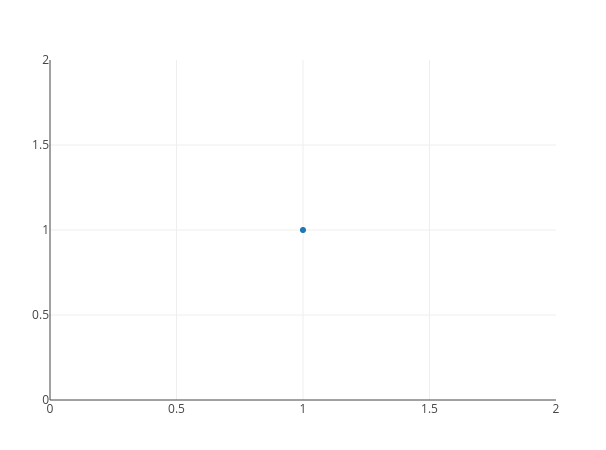

In [32]:
scatter1 = scatter(x=[1.0],y=[1.0])
plt=plot([scatter1])


In [34]:
for i=1:15
    extendtraces(plt,x=[[i]],y=[[randn()]],1)
    sleep(0.1)
end